In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from keras_visualizer import visualizer 


In [4]:
print(tf.__version__)

2.5.0


In [5]:
df_data = pd.read_csv("./house-prices-data/house-prices-data.csv")

dataset = df_data.copy()

## Separating Data

In [6]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

dataset_X = dataset.drop(["Id","SalePrice"], axis = 1)
dataset_id = dataset["Id"]
dataset_y = dataset["SalePrice"]

train_dataset_X = train_dataset.drop(["Id","SalePrice"], axis = 1)
train_dataset_id = train_dataset["Id"]
train_dataset_y = train_dataset["SalePrice"]

test_dataset_X = test_dataset.drop(["Id","SalePrice"], axis = 1)
test_dataset_id = test_dataset["Id"]
test_dataset_y = test_dataset["SalePrice"]

# or use the train_test splitter from scikit learn

# Write the example here with sklearn

In [7]:
print("Training dataset has", len(train_dataset_X), "values.")
print("Testing dataset has", len(test_dataset_X), "values.")

Training dataset has 1168 values.
Testing dataset has 292 values.


## Normalization

La normalisation est une transformation de la donnée qui permet de "normaliser" la moyenne et la deviation standard d'une distribution. Pour cela on déplace chaque valeur par l'écart et divisant par la déviation standard. Cela permet de ne pas avoir de valeurs trop de difference entre les differentes features de notre dataset et permet aussi de rendre notre convergence plus stable pour nos modèles. 

In [8]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
Id,730.949486,421.221360
MSSubClass,57.572774,42.053072
MSZoning,3.032534,0.631075
LotFrontage,200.055651,3121.409754
LotArea,10549.443493,9906.540386
...,...,...
MoSold,6.366438,2.701544
YrSold,2007.819349,1.318539
SaleType,7.482021,1.585502
SaleCondition,3.761130,1.134621


### The 'old' way : Pandas

In [9]:
def normalize(x, mean, std): 
    return ((x-mean)/std)

In [10]:
def normalizeColumn(df, colName):
    meanVal = df[colName].mean()
    stdVal = df[colName].std()
    print(meanVal, stdVal)

    newCol = df[colName].apply(lambda x: normalize(x,meanVal, stdVal))
    newMean = newCol.mean()
    newStd = newCol.std()
    print(newMean, newStd)
    
    return newCol

In [11]:
normalizeColumn(dataset_X, "MSZoning")

3.0287671232876714 0.6320174410566584
-2.822704018773001e-16 0.9999999999999998


0      -0.045516
1      -0.045516
2      -0.045516
3      -0.045516
4      -0.045516
          ...   
1455   -0.045516
1456   -0.045516
1457   -0.045516
1458   -0.045516
1459   -0.045516
Name: MSZoning, Length: 1460, dtype: float64

We can transform the complete dataset with a simple line

In [12]:
dataset_X-dataset_X.mean()/dataset_X.std()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,58.654929,-1.792221,64.943808,8448.946343,-14.561727,1.62154,-0.92473,-0.026171,2.139336,-0.225639,...,60.295758,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,-0.338311,496.198833,3.159453,0.57489
1,18.654929,-1.792221,79.943808,9598.946343,-14.561727,1.62154,-0.92473,-0.026171,0.139336,-0.225639,...,-0.704242,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,2.661689,495.198833,3.159453,0.57489
2,58.654929,-1.792221,67.943808,11248.946343,-14.561727,-1.37846,-0.92473,-0.026171,2.139336,-0.225639,...,41.295758,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,6.661689,496.198833,3.159453,0.57489
3,68.654929,-1.792221,59.943808,9548.946343,-14.561727,-1.37846,-0.92473,-0.026171,-1.860664,-0.225639,...,34.295758,271.640798,-0.116299,-0.270116,-0.068668,-0.087658,-0.338311,494.198833,3.159453,-3.42511
4,58.654929,-1.792221,83.943808,14258.946343,-14.561727,-1.37846,-0.92473,-0.026171,0.139336,-0.225639,...,83.295758,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,9.661689,496.198833,3.159453,0.57489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,58.654929,-1.792221,61.943808,7915.946343,-14.561727,1.62154,-0.92473,-0.026171,2.139336,-0.225639,...,39.295758,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,5.661689,495.198833,3.159453,0.57489
1456,18.654929,-1.792221,84.943808,13173.946343,-14.561727,1.62154,-0.92473,-0.026171,2.139336,-0.225639,...,-0.704242,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,-0.338311,498.198833,3.159453,0.57489
1457,68.654929,-1.792221,65.943808,9040.946343,-14.561727,1.62154,-0.92473,-0.026171,2.139336,-0.225639,...,59.295758,-0.359202,-0.116299,-0.270116,-0.068668,2499.912342,2.661689,498.198833,3.159453,0.57489
1458,18.654929,-1.792221,67.943808,9715.946343,-14.561727,1.62154,-0.92473,-0.026171,2.139336,-0.225639,...,-0.704242,111.640798,-0.116299,-0.270116,-0.068668,-0.087658,1.661689,498.198833,3.159453,0.57489


### A bit of help from Scikit Learn?

In [13]:
from sklearn import preprocessing

x = dataset_X.values #returns a numpy array
col = dataset_X.columns
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_dataset_X = pd.DataFrame(x_scaled, columns=col)
normalized_dataset_X.describe()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.217043,0.757192,0.001740,0.043080,0.995890,0.647489,0.925799,0.000685,0.754795,0.031164,...,0.085302,0.039772,0.006712,0.031377,0.003738,0.002806,0.483811,0.453938,0.939127,0.754110
std,0.248827,0.158004,0.030958,0.046653,0.063996,0.469719,0.235889,0.026171,0.405659,0.138116,...,0.121126,0.110723,0.057711,0.116161,0.054441,0.032008,0.245784,0.332024,0.194013,0.220171
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.750000,0.000297,0.029229,1.000000,0.000000,1.000000,0.000000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.363636,0.250000,1.000000,0.800000
50%,0.176471,0.750000,0.000386,0.038227,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,0.045704,0.000000,0.000000,0.000000,0.000000,0.000000,0.454545,0.500000,1.000000,0.800000
75%,0.294118,0.750000,0.000475,0.048150,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,0.124314,0.000000,0.000000,0.000000,0.000000,0.000000,0.636364,0.750000,1.000000,0.800000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Normalization with TensorFlow 

Normalization can be added directy in our models so that we don't have to worry about it anymore !

In [14]:
from tensorflow.keras.layers.experimental import preprocessing

normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_dataset_X))
print(normalizer.mean.numpy())

[5.75727577e+01 3.03253508e+00 2.00055664e+02 1.05494443e+04
 9.96575475e-01 1.94606161e+00 2.76626730e+00 8.56164377e-04
 3.06678057e+00 6.07876703e-02 1.23202047e+01 2.03253388e+00
 2.01027393e+00 4.88013774e-01 3.04794431e+00 6.15325212e+00
 5.58647346e+00 1.97117981e+03 1.98508813e+03 1.40924621e+00
 1.07619846e+00 9.56164265e+00 1.03047962e+01 1.76626718e+00
 1.05862999e+02 2.52654076e+00 3.73544526e+00 1.39041102e+00
 2.27911019e+00 2.83304763e+00 2.29623318e+00 2.82191706e+00
 4.43898987e+02 4.74914455e+00 4.65042763e+01 5.75950378e+02
 1.06635352e+03 1.03681505e+00 1.51369882e+00 9.34075296e-01
 3.69948649e+00 1.16843384e+03 3.55280823e+02 6.92465782e+00
 1.53063940e+03 4.29794461e-01 5.65068498e-02 1.56763673e+00
 3.91267031e-01 2.86130071e+00 1.04708874e+00 2.32705450e+00
 6.55308199e+00 5.76027489e+00 6.21575415e-01 3.77910924e+00
 2.51712322e+00 1.88355994e+03 1.27825356e+00 1.78424644e+00
 4.77242340e+02 3.93321848e+00 3.96575356e+00 1.86301351e+00
 9.43647156e+01 4.702567

## Linear Regression

### A shallow network

`keras` used to live as a separate entity from `tensorflow`. It is an interface built on top of `theano` and `tensorflow` to simplify some of their non-beginner-friendly methods. It was integrated inside `tensorflow` in 2019. 

We can use the `tf.keras.Sequential` from the `tf.keras` API to build our first shallow model.

In [15]:
shallow_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

shallow_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 75)                151       
_________________________________________________________________
dense (Dense)                (None, 1)                 76        
Total params: 227
Trainable params: 76
Non-trainable params: 151
_________________________________________________________________


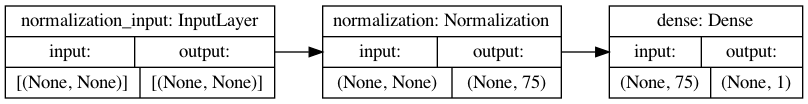

In [16]:
#visualizer(shallow_model, format='png', view=True)
plot_model(shallow_model, to_file='shallow_model.png', show_shapes=True, rankdir='LR')

In [17]:
shallow_model.predict(train_dataset_X)

array([[ 3.306381  ],
       [ 0.5623585 ],
       [ 0.06214246],
       ...,
       [ 0.25930962],
       [-0.02199333],
       [ 0.95170766]], dtype=float32)

In [18]:
shallow_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.8),
    loss='mean_absolute_error')

In [19]:
%%time
history = shallow_model.fit(
    train_dataset_X, train_dataset_y,
    epochs=10000,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 5min 43s, sys: 50.2 s, total: 6min 33s
Wall time: 4min 38s


In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
9995,17055.457031,17865.146484,9995
9996,17056.099609,17863.785156,9996
9997,17056.404297,17863.470703,9997
9998,17055.494141,17865.250000,9998
9999,17056.115234,17865.908203,9999


In [21]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error J')
  plt.legend()
  plt.grid(True)

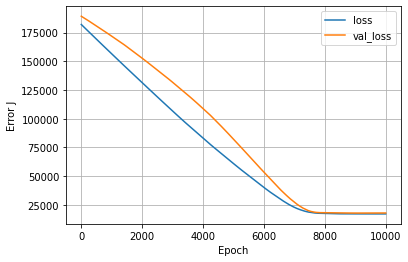

In [22]:
plot_loss(history)

In [23]:
train_dataset_hat_y = shallow_model.predict(train_dataset_X)

In [24]:
 test_cost = shallow_model.evaluate(
    test_dataset_X, test_dataset_y, verbose=0)

print("Error at testing is : ", test_cost)

Error at testing is :  17413.724609375


In [25]:
def f(x):
    val = x
    valUp = val + 1

    prediction = shallow_model.predict(test_dataset_X[val:valUp])[0][0]

    print("For example prediction for the house",x ,"is", prediction, "and its real price is", test_dataset_y[val:valUp].values[0])
    print("The price difference is", test_dataset_y[val:valUp].values[0] - prediction, "$")

    plt.bar(["Objective", "Prediction"], [test_dataset_y[val:valUp].values[0], prediction])
    plt.ylim([0,test_dataset_y.max()])




lenTestset = len(test_dataset_X)-1
interact(f, x=widgets.IntSlider(min=0, max=lenTestset, step=1, value=0))
plt.show()


interactive(children=(IntSlider(value=0, description='x', max=291), Output()), _dom_classes=('widget-interact'…

## Deep Neural Networks

explanations

In [32]:
deep_model_long = keras.Sequential([
      normalizer,
      layers.Dense(128, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

deep_model_long.compile(loss='mean_absolute_error',
            optimizer=tf.keras.optimizers.Adam(0.001))

In [33]:
deep_model_long.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 75)                151       
_________________________________________________________________
dense_6 (Dense)              (None, 128)               9728      
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 51,224
Trainable params: 51,073
Non-trainable params: 151
________________________________________________

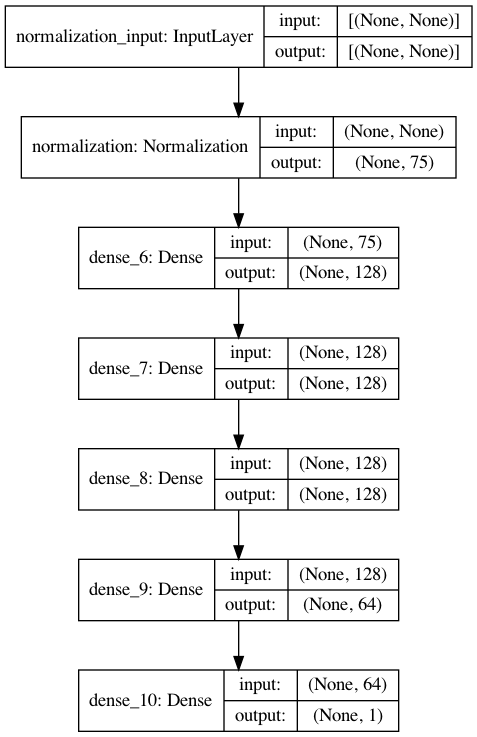

In [34]:
plot_model(deep_model_long, to_file='deep_model.png', show_shapes=True)

In [35]:
%%time
history = deep_model_long.fit(
    train_dataset_X, train_dataset_y,
    validation_split=0.2,
    verbose=0, epochs=10)

CPU times: user 1.25 s, sys: 562 ms, total: 1.81 s
Wall time: 845 ms


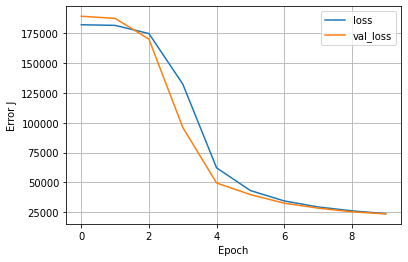

In [36]:
plot_loss(history)

In [37]:
for i in range(1, 30):
    
    history = deep_model_long.fit(
    train_dataset_X, train_dataset_y,
    validation_split=0.2,
    verbose=0, epochs=10)
    
    test_cost = deep_model_long.evaluate(
    test_dataset_X, test_dataset_y, verbose=0)

    print("Error at testing is : ", test_cost)

Error at testing is :  51800.203125
Error at testing is :  48013.171875
Error at testing is :  44218.5625
Error at testing is :  41840.94921875
Error at testing is :  40037.67578125
Error at testing is :  38701.75
Error at testing is :  37620.9609375
Error at testing is :  37069.02734375
Error at testing is :  36577.06640625
Error at testing is :  36139.94921875
Error at testing is :  36081.71484375
Error at testing is :  36042.12890625
Error at testing is :  35989.42578125
Error at testing is :  36043.98828125
Error at testing is :  36200.7421875
Error at testing is :  36347.74609375
Error at testing is :  35894.921875
Error at testing is :  35795.0
Error at testing is :  36585.34375
Error at testing is :  36209.12890625
Error at testing is :  36773.0
Error at testing is :  36696.453125
Error at testing is :  36864.89453125
Error at testing is :  36974.84765625
Error at testing is :  36816.921875
Error at testing is :  37595.6953125
Error at testing is :  38116.87890625
Error at testi

In [90]:
deep_model = keras.Sequential([
      normalizer,
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

deep_model.compile(loss='mean_absolute_error',
            optimizer=tf.keras.optimizers.Adam(0.01))

history = deep_model.fit(
    train_dataset_X, train_dataset_y,
    validation_split=0.2,
    verbose=0, epochs=10)

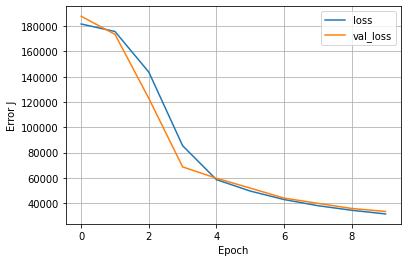

In [91]:
plot_loss(history)

In [92]:
whileFlag = True
upBoundary = 1000000000

while whileFlag:
    
    history = deep_model.fit(
    train_dataset_X, train_dataset_y,
    validation_split=0.2,
    verbose=0, epochs=10)
    
    test_cost = deep_model.evaluate(
    test_dataset_X, test_dataset_y, verbose=0)

    print("Error at testing is : ", test_cost)
    if(upBoundary > test_cost):
        upBoundary = test_cost
    else: 
        whileFlag = False

Error at testing is :  56556.48046875
Error at testing is :  50356.34375
Error at testing is :  42198.4765625
Error at testing is :  38547.3046875
Error at testing is :  35081.08203125
Error at testing is :  33722.5234375
Error at testing is :  32987.45703125
Error at testing is :  32905.4609375
Error at testing is :  32238.66015625
Error at testing is :  32131.05078125
Error at testing is :  32417.828125


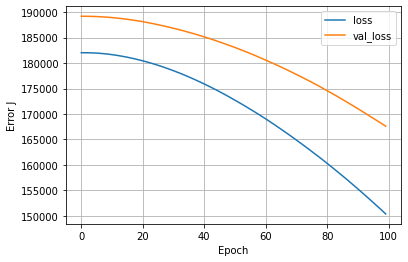

In [125]:
deep_model_short = keras.Sequential([
      normalizer,
      layers.Dense(64),
      layers.Dense(1)
  ])

deep_model_short.compile(
    loss='mean_absolute_error',
    optimizer=tf.optimizers.Adam(learning_rate=0.005)
)

history = deep_model_short.fit(
    train_dataset_X, train_dataset_y,
    validation_split=0.2,
    verbose=0, epochs=100)

plot_loss(history)

In [126]:
whileFlag = True
upBoundary = 1000000000

while whileFlag:
    
    history = deep_model_short.fit(
    train_dataset_X, train_dataset_y,
    validation_split=0.2,
    verbose=0, epochs=2)
    
    test_cost = deep_model_short.evaluate(
    test_dataset_X, test_dataset_y, verbose=0)


    print("Cost is ", np.mean(history.history['loss']), "Error at testing is : ", test_cost)
    print()
    if(upBoundary > test_cost):
        upBoundary = test_cost
    else: 
        whileFlag = False

Cost is  149509.1796875 Error at testing is :  138854.984375

Cost is  148388.8828125 Error at testing is :  137925.4375

Cost is  147248.6171875 Error at testing is :  136976.59375

Cost is  146121.3125 Error at testing is :  135930.140625

Cost is  144960.015625 Error at testing is :  134932.171875

Cost is  143800.3203125 Error at testing is :  133937.0625

Cost is  142609.1796875 Error at testing is :  132887.390625

Cost is  141421.5234375 Error at testing is :  131708.4375

Cost is  140206.1640625 Error at testing is :  130613.3984375

Cost is  138965.640625 Error at testing is :  129523.8203125

Cost is  137724.9765625 Error at testing is :  128316.2734375

Cost is  136466.96875 Error at testing is :  127154.4140625

Cost is  135179.578125 Error at testing is :  125966.8515625

Cost is  133891.5078125 Error at testing is :  124745.5078125

Cost is  132567.2265625 Error at testing is :  123554.0546875

Cost is  131251.08203125 Error at testing is :  122371.1484375

Cost is  12993

## TF utilities

### Saving models

### Controlled Randomness